#### Character to Mel Spectrogram Sequence Generation Model with location-based Attention

In [263]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import pickle
sys.path.append('../../')
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
from tools.libaudio.utils import load
from tools.libaudio.feature import melspectrogram
from tools.libaudio.waves import sin_wave
from tools.libaudio.display import show_spec, show_mel
from mlutils.utils import plot, plots, to_onehot
from models.phoneme import Phoneme43
import torch
import torch.nn as nn
import torch.nn.functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload




**RNN Sequence Genetor with location-based Attention**
```

U: char length
c: char sequence
T: timestep length of input x
wt: window into c at timestep t
φ(t, u): window weight of cu at timestep t
αt: parameters control the importance of the window within the mixture
βt: parameters control the width of the window
kt: parameters control the location of the window

ht^1 = H(Wih1 xt + Wh1h1 h1t-1 + Wwh1 wt-1 + b1h)

(αhat_t, βhat_t, khat_t) = Wh1p ht^1 + bp  # output of the first hidden layer

αt = exp(αhat_t)  # importance of the window
βt = exp(βhat_t)  # width of the window
kt = kt-1 + exp(khat_t)  # location of the window (how far to slide each window)

φ(t, u) = Σk=1->K αt^k exp(-βt^k(kt^k-u)^2)  # discrete convolution of a mixture of K Gaussian


ht^n = H(Wihn xt + Whn-1hn ht^n-1 + Whnhn ht-1^n + Wwhn wt + bh^n)


```

ref. Generating Sequences With Recurrent Neural Networks  
https://arxiv.org/pdf/1308.0850.pdf

**Char to MelSpectrum model**
```
seq of char (n,)
-> embedding (N_char, 512)
-> conv (shape:5x1, filter:512)+batch norm+relu x 3
-> bi-GRU (256 hidden size  x 2)
-> (encoded features)
-> attention network
-> (attention context)
-> residual uni-GRU (1024 hidden size) x 2
-> fully connected (256) x2 + (attention context)
-> residual uni-GRU (1024 hidden size) x 2
-> Mel spectrogram
```
ref. NATURAL TTS SYNTHESIS BY CONDITIONING WAVENET ON MEL SPECTROGRAM PREDICTIONS  
https://arxiv.org/pdf/1712.05884.pdf


Mel Spectrogram

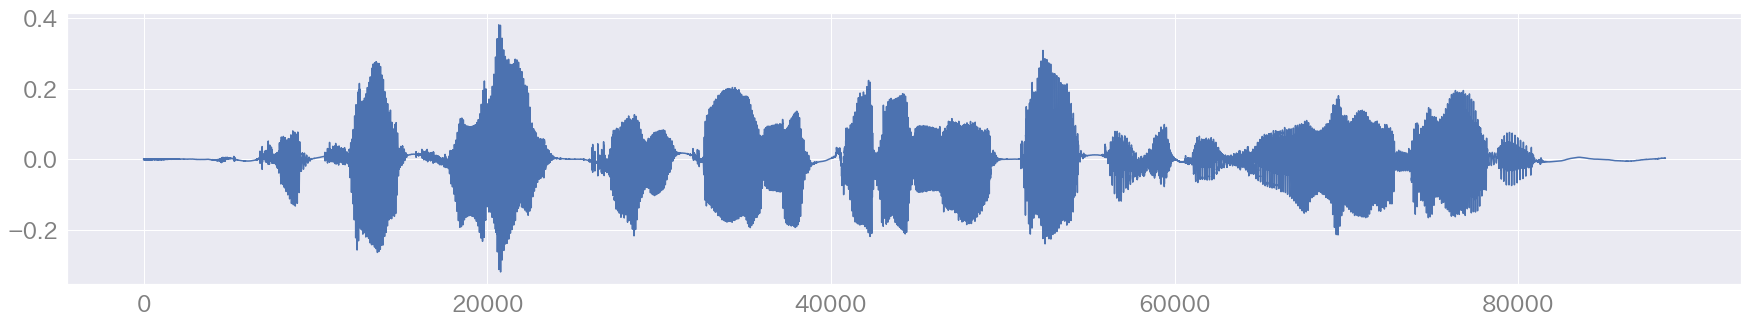

In [264]:
key = 'BASIC5000_0005'
wav_005 = load(f'/diskB/6/Datasets/VoiceData/jsut_ver1.1/basic5000/wav/{key}.wav', sample_rate=24000)
plot(wav_005)

In [265]:
ipd.Audio(wav_005, rate=24000)

In [266]:
text_005 = 'ケツアツハケンコウノバロメータートシテジュウヨウデアル'

In [267]:
wav_005.shape

(88560,)

In [268]:
mel = melspectrogram(wav_005, sample_rate=24000, n_fft=2048, hop_length=300, power=2.0)

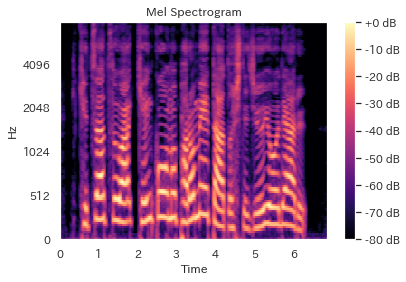

In [269]:
show_mel(mel)

In [270]:
mel = torch.Tensor(mel)
mel.shape

torch.Size([128, 296])

Phoneme (Character) indices

In [271]:
with open('/diskB/6/Datasets/VoiceData/jsut_ver1.1/preprocessed/segments.pickle', 'rb') as f:
    segments = pickle.load(f)
    print(f'segments[0] {segments[0]}')

segments[0] ('/diskB/6/Datasets/VoiceData/jsut_ver1.1/segmentation_results/all/BASIC5000_1701.log', [(26, 30, 'b'), (31, 36, 'o'), (37, 42, 'k'), (43, 46, 'u'), (47, 54, 'n'), (55, 62, 'a'), (63, 67, 'r'), (68, 80, 'a'), (81, 94, 'n'), (95, 99, 'a'), (100, 108, 'n'), (109, 114, 'i'), (115, 124, 'o'), (125, 133, 'o'), (134, 138, 'i'), (139, 145, 't'), (146, 148, 'e'), (149, 158, 'm'), (159, 172, 'o'), (173, 183, 'd'), (184, 192, 'o:'), (193, 204, 's'), (205, 216, 'o:'), (217, 226, 'k'), (227, 233, 'a'), (234, 236, 'i'), (237, 245, 'w'), (246, 250, 'a'), (251, 260, 'k'), (261, 263, 'a'), (264, 269, 'n'), (270, 274, 'a'), (275, 279, 'r'), (280, 282, 'a'), (283, 291, 'z'), (292, 294, 'u'), (295, 306, 'sh'), (307, 309, 'u'), (310, 312, 'q'), (313, 321, 's'), (322, 327, 'e'), (328, 332, 'k'), (333, 335, 'i'), (336, 345, 's'), (346, 349, 'u'), (350, 353, 'r'), (354, 358, 'u'), (359, 361, 'd'), (362, 367, 'a'), (368, 375, 'r'), (376, 392, 'o'), (393, 395, 'u')])


In [272]:
def search(key):
    for d in segments:
        if d[0].endswith(f'{key}.log'):
            return d

In [273]:
phonemes = [Phoneme43.to_index(phone[2]) for phone in search(key)[1]]

In [274]:
print(phonemes)

[25, 3, 26, 2, 0, 26, 2, 11, 0, 25, 3, 10, 25, 9, 33, 4, 23, 0, 38, 4, 32, 8, 24, 5, 24, 4, 35, 1, 24, 3, 13, 7, 12, 9, 29, 3, 0, 38, 2]


In [275]:
phoneme_names = [Phoneme43(phoneme).name for phoneme in phonemes]
phoneme_names[:10]

['k', 'e', 'ts', 'u', 'a', 'ts', 'u', 'w', 'a', 'k']

Character encoding

In [276]:
vocab_size = len(Phoneme43)

x = torch.LongTensor(to_onehot(phonemes, n_class=vocab_size))

In [277]:
x

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])

In [278]:
x.shape

torch.Size([39, 43])

In [279]:
embed_size = 512
embedding = nn.Embedding(vocab_size, embed_size)

In [280]:
x_emb = embedding(x)

In [281]:
x_emb[0]

tensor([[ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        ...,
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685]],
       grad_fn=<SelectBackward>)

In [282]:
x_emb.shape  # (T, H, W)

torch.Size([39, 43, 512])

In [283]:
class NGramConvolution(torch.nn.Module):
    def __init__(self, embed_size=512, kernel_size=(5, 1)):
        super(NGramConvolution, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=embed_size, out_channels=embed_size, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv2d(in_channels=embed_size, out_channels=embed_size, kernel_size=kernel_size)
        self.conv3 = torch.nn.Conv2d(in_channels=embed_size, out_channels=embed_size, kernel_size=kernel_size)
        self.bn1 = torch.nn.BatchNorm2d(num_features=embed_size)
        self.bn2 = torch.nn.BatchNorm2d(num_features=embed_size)
        self.bn3 = torch.nn.BatchNorm2d(num_features=embed_size)
        self.relu1 = torch.nn.ReLU()
        self.relu2 = torch.nn.ReLU()
        self.relu3 = torch.nn.ReLU()
    
    def THW2NWTH(self, x):
        x = x.permute(2, 0, 1)
        return x.view(1, x.shape[0], x.shape[1], x.shape[2])
    
    def forward(self, x):
        if len(x.shape) == 3:
            x = self.THW2NWTH(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu2(x)
        x = x.permute(2, 0, 3, 1)  # (T, N, H, W)
        return x

In [284]:
ngc = NGramConvolution(embed_size=embed_size, kernel_size=(5, 1))

In [285]:
%%time
x_emb_c = ngc(x_emb)

CPU times: user 3.58 s, sys: 220 ms, total: 3.8 s
Wall time: 196 ms


In [286]:
x_emb_c[0][0]

tensor([[0.0000, 0.0000, 1.5784,  ..., 3.8419, 1.1681, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0004],
        [0.0000, 0.0000, 1.5156,  ..., 1.5452, 1.3186, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0004],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0004],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0004]],
       grad_fn=<SelectBackward>)

In [287]:
x_emb_c.shape

torch.Size([27, 1, 43, 512])

####  Sequence Generator with location-based Attention

```
x: input sequence
y: mel spectrum sequence
U: char length
c: char sequence
T: timestep length of input x
wt: window vector into c at timestep t
φ(t, u): window weight of cu at timestep t
αt: parameters control the importance of the window within the mixture
βt: parameters control the width of the window
κt: parameters control the location of the window
(eq.46): discrete convolution with a mixture of K Gaussian function

xt ∈ R×R×{0,1}

h1t = H(Wih1 xt + Wh1h1 h1t-1 + Wwh1 wt-1 + b1h)

(αhat_t, βhat_t, khat_t) = Wh1p ht^1 + bp  # output of the first hidden layer

αt = exp(αhat_t)  # importance of the window
βt = exp(βhat_t)  # width of the window
κt = κt-1 + exp(κhat_t)  # location of the window (how far to slide each window)

φ(t, u) = Σk=1->K αkt*exp(-βkt(κkt-u)^2)  # mixture of K Gaussian


cf. 
normal distribution
N(X|μ,σ2) = 1/(2πσ2)^1/2 exp{-1/2σ2(x-μ)2}

mixture gaussians
p(x) = Σk=1->K πk N(X|μk,Σk)  # where πk:mixing coefficient, μk:mean, Σk:covariance, N(X|μk,Σk):mixture component
p(x) = Σk=1->K πk (1/(2π)^D/2 1/|Σ|^1/2) exp{-1/2(x-μ)^T Σ^-1(x-μ)}  # where Σ:DxD dim covariance matrix, |Σ|:det Σ

wt = Σu=1->U φ(t, u)*cu  # the soft window into c at timestep t

hnt = H(Wihn xt + Whn-1hn hnt-1 + Whnhn hnt-1 + Wwhn wt + bnh)

yˆtˆ = (eˆt,{wˆj_t,μˆJ_t,σˆj_t,ρˆj_t}^M_j=1) = by + Σn=1->N Whny hnt

et = 1 / (1 + exp(eˆt)) ⇒ et∈(0,1) : stroke probability
πtj = exp(πtj) / (Σj't=1->M exp(πtj)) ⇒πtj∈(0,1), Σπtj=1 : mixture weights
μjt = μˆjt ⇒ μjt∈R : means
σtj = exp(σˆtj) ⇒ σˆtj > 0 : std
pjt = tanh(pˆtj) ⇒ pˆtj∈(0,1) : correlations

Pr(x|c) = ∏t=1->T Pr(xt+1|yt)
L(x) = -log Pr(x|c)
```

Input & Output

In [288]:
# c1. onehot
x

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]])

In [289]:
x.shape

torch.Size([39, 43])

In [290]:
# c2. onehot embeded
x_emb[0]

tensor([[ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        ...,
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685],
        [ 0.1277, -0.8859,  1.1535,  ...,  1.9341, -0.2470, -0.3685]],
       grad_fn=<SelectBackward>)

In [291]:
x_emb.shape

torch.Size([39, 43, 512])

In [292]:
# c3. onehot embedded 5-gram
x_emb_c[0][0]

tensor([[0.0000, 0.0000, 1.5784,  ..., 3.8419, 1.1681, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0004],
        [0.0000, 0.0000, 1.5156,  ..., 1.5452, 1.3186, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0004],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0004],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0004]],
       grad_fn=<SelectBackward>)

In [293]:
x_emb_c.shape

torch.Size([27, 1, 43, 512])

In [294]:
# y. melspectrogram
mel

tensor([[4.1781e-04, 4.2978e-04, 3.8574e-04,  ..., 1.8835e-02, 3.2648e-02,
         4.3341e-02],
        [1.1756e-04, 1.4426e-04, 1.5435e-04,  ..., 2.5821e-04, 3.2323e-04,
         3.2827e-04],
        [2.8792e-05, 4.0903e-05, 6.2976e-05,  ..., 4.9818e-05, 5.0324e-05,
         7.5028e-05],
        ...,
        [3.7895e-07, 4.1616e-07, 3.6224e-07,  ..., 1.5572e-08, 3.1202e-08,
         4.8096e-08],
        [2.7661e-07, 2.4075e-07, 1.4813e-07,  ..., 6.5611e-09, 1.0549e-08,
         1.5595e-08],
        [1.1432e-07, 7.7864e-08, 2.2786e-08,  ..., 8.3096e-10, 2.5113e-09,
         4.2880e-09]])

In [295]:
mel.shape

torch.Size([128, 296])

Parameters

In [296]:
K = vocab_len  # mixture of K Gaussian
padded_text_len = 999   # text length with padding (=max sequence len) from data set
U = vocab_len = n_chars = 43  # num of characters
hidden_size = 256
mel_feature_size = mel.shape[1]  # 296
batch_size = 1
T = max_target_size = 800  # max time step

Input data

In [297]:
# y: mel spectrogram (N, T, H)
y = mel.view(batch_size, mel.shape[0], mel.shape[1])

In [298]:
# add padding to x according to max_target_size (T) 
y = torch.cat([y, torch.zeros((y.shape[0], T-y.shape[1], y.shape[2]))], dim=1)
y.shape

torch.Size([1, 800, 296])

In [299]:
# time step 0 for x
y[:, 0, :].shape

torch.Size([1, 296])

In [300]:
# reshape x:text sequence from (T, H) to (N, T, H)
x = x.view(batch_size, x.shape[0], x.shape[1])
x.shape

torch.Size([1, 39, 43])

Hidden Layers

In [321]:
# GRUCell only returns the next hidden state (batch, hidden_size)

# h1t = H(Wih1 xt + Wh1h1 h1t-1 + Wwh1 wt-1 + b1h) = H(Wiwh1 (xt + wt-1) + Wh1h1 h1t-1 + b1h)
H1 = torch.nn.GRUCell(input_size=vocab_size+3, hidden_size=hidden_size)  # NOTE: 3? window size?
H2 = torch.nn.GRUCell(input_size=vocab_size+3+hidden_size, hidden_size=hidden_size)

In [302]:
# begin with the first timestep
t = 0
xt_1 = x[:, t, :]
xt_1.shape  # TODO: must be size of vocab len (43)

torch.Size([1, 43])

In [303]:
# the first window is from the first character (phoneme 0: "a")
wt_1 = torch.zeros((batch_size, 3)).long()
wt_1.shape

torch.Size([1, 3])

In [304]:
# initial input (N, vocab_size+3(alpha,beta,kappa))
xt_1_wt_1 = torch.cat([xt_1, wt_1], dim=-1).float()
xt_1_wt_1.shape

torch.Size([1, 46])

In [305]:
# initial hidden state
ht_1 = torch.zeros(batch_size, hidden_size)
ht_1.shape

torch.Size([1, 256])

In [306]:
# h1t = H(Wih1 xt + Wh1h1 h1t-1 + Wwh1 wt-1 + b1h)
h1t_1 = H1(xt_1_wt_1, ht_1)
h1t_1.shape

torch.Size([1, 256])

In [307]:
# initial kappa
kappa_t_1 = torch.zeros((batch_size, K))
kappa_t_1.shape

torch.Size([1, 43])

In [308]:
# (αhat_t, βhat_t, khat_t) = Wh1p ht^1 + bp  # output of the first hidden layer
Wh1p = torch.nn.Linear(hidden_size, 3*K)
bp = torch.nn.Parameter(torch.zeros(3*K))
alpha_beta_kappa = Wh1p(h1t_1) + bp
alpha_t, beta_t, kappa_t = alpha_beta_kappa[:, :K], alpha_beta_kappa[:, K:K*2], alpha_beta_kappa[:, K*2:K*3]
# αt = exp(αhat_t)  # importance of the window
# βt = exp(βhat_t)  # width of the window
# κt = κt-1 + exp(κhat_t)  # location of the window (how far to slide each window)
alpha_t = alpha_t.exp()
beta_t = beta_t.exp()
kappa_t = kappa_t_1 + kappa_t.exp()
alpha_t.shape, beta_t.shape, kappa_t.shape

(torch.Size([1, 43]), torch.Size([1, 43]), torch.Size([1, 43]))

In [309]:
kappa_t.unsqueeze(2).repeat(1, 1, x.shape[1])

tensor([[[0.9620, 0.9620, 0.9620,  ..., 0.9620, 0.9620, 0.9620],
         [0.9624, 0.9624, 0.9624,  ..., 0.9624, 0.9624, 0.9624],
         [1.0692, 1.0692, 1.0692,  ..., 1.0692, 1.0692, 1.0692],
         ...,
         [1.0156, 1.0156, 1.0156,  ..., 1.0156, 1.0156, 1.0156],
         [0.9990, 0.9990, 0.9990,  ..., 0.9990, 0.9990, 0.9990],
         [0.9674, 0.9674, 0.9674,  ..., 0.9674, 0.9674, 0.9674]]],
       grad_fn=<RepeatBackward>)

In [310]:
torch.Tensor(range(U)).view(1, -1)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
         28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
         42.]])

In [322]:
u = torch.Tensor(range(x.shape[1])).view(1, -1)
kappa_t.unsqueeze(2).repeat(1, 1, x.shape[1]) - u

tensor([[[ 9.6203e-01, -3.7973e-02, -1.0380e+00,  ..., -3.5038e+01,
          -3.6038e+01, -3.7038e+01],
         [ 9.6236e-01, -3.7638e-02, -1.0376e+00,  ..., -3.5038e+01,
          -3.6038e+01, -3.7038e+01],
         [ 1.0692e+00,  6.9233e-02, -9.3077e-01,  ..., -3.4931e+01,
          -3.5931e+01, -3.6931e+01],
         ...,
         [ 1.0156e+00,  1.5598e-02, -9.8440e-01,  ..., -3.4984e+01,
          -3.5984e+01, -3.6984e+01],
         [ 9.9903e-01, -9.7132e-04, -1.0010e+00,  ..., -3.5001e+01,
          -3.6001e+01, -3.7001e+01],
         [ 9.6739e-01, -3.2612e-02, -1.0326e+00,  ..., -3.5033e+01,
          -3.6033e+01, -3.7033e+01]]], grad_fn=<ThSubBackward>)

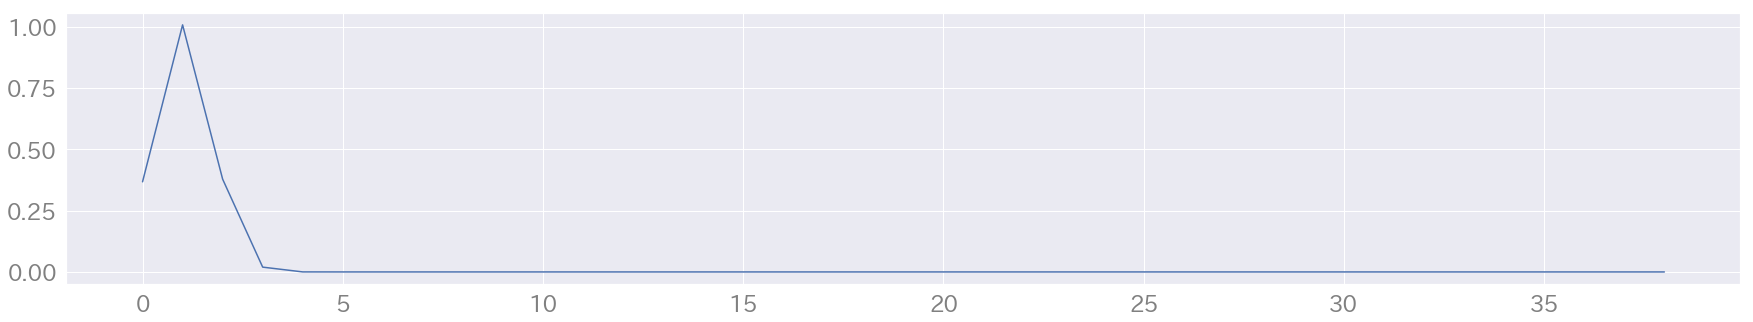

In [323]:
u = torch.Tensor(range(x.shape[1])).view(1, -1)
a = alpha_t.unsqueeze(2) * (-beta_t.unsqueeze(2)*(kappa_t.unsqueeze(2).repeat(1, 1, x.shape[1]) - u)**2).exp()
a = a.sum(dim=1) / K
a = a.squeeze(0).detach().numpy()
plot(a)

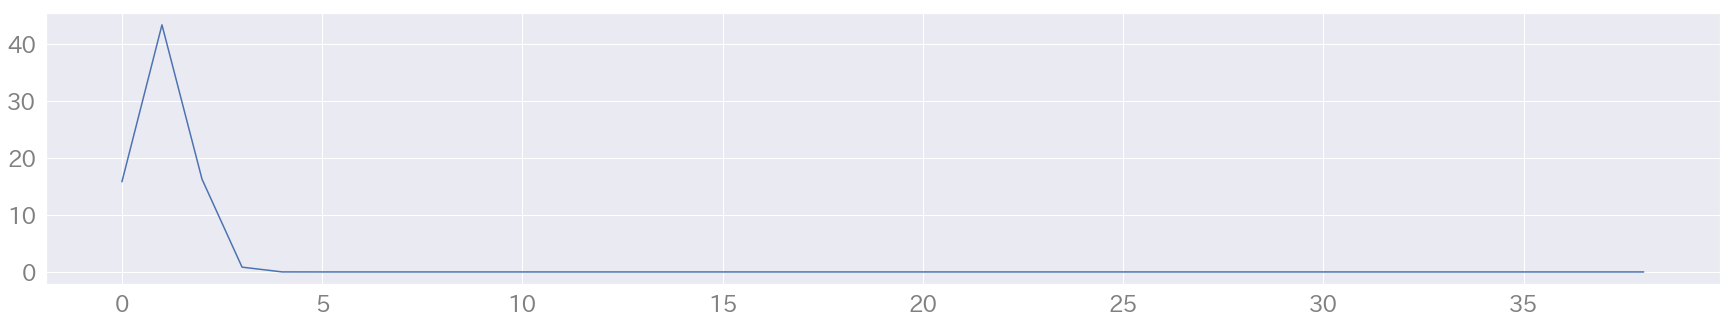

In [325]:
# φ(t, u) = Σk=1->K αkt*exp(-βkt(κkt-u)^2)  # mixture of K Gaussian

# unefficient way
#phi_t = torch.stack([alpha_t*(-beta_t*(kappa_t-u)**2).exp() for u in range(x.shape[1])]).permute(1, 2, 0)  # (N, K, U)
#phi_t = torch.sum(phi_t, dim=1)  # linear combination of K columns to a mixture distribution length U (N, U)
#phi_t, phi_t.shape

u = torch.Tensor(range(x.shape[1]))
phi_t = (alpha_t.unsqueeze(2) * (-beta_t.unsqueeze(2) * (kappa_t.unsqueeze(2).repeat(1, 1, x.shape[1]) - u)**2).exp()).sum(dim=1)
phi_t, phi_t.shape

#u = torch.Tensor(range(U))
#phi_t = (alpha_t.unsqueeze(2) * (-beta_t.unsqueeze(2) * (kappa_t.unsqueeze(2).repeat(1, 1, U) - u)**2).exp()).sum(dim=1)
#phi_t, phi_t.shape
#alpha_t*(-beta_t*(kappa_t-0)**2).exp()
plot(phi_t.squeeze(0).detach().numpy())

In [348]:
x, x.shape, phi_t, phi_t.shape

(tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 1,  ..., 0, 0, 0]]]),
 torch.Size([1, 39, 43]),
 tensor([[15.8055, 43.3287, 16.2702,  0.8441,  0.0062,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
        grad_fn=<SumBackward1>),
 torch.Size([1, 39]))

In [350]:
# wt = Σu=1->U φ(t, u)*cu  # the soft window into c at timestep t
# The size of the soft window vectors is the same as the size of the character vectors
# cu (assuming a one-hot encoding, this will be the number of characters in the alphabet).
wt = (x.float() * phi_t.unsqueeze(2))
#wt = phi_t.transpose(0, 1)*x.float()
wt, wt.shape

(tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
        grad_fn=<ThMulBackward>), torch.Size([1, 39, 43]))

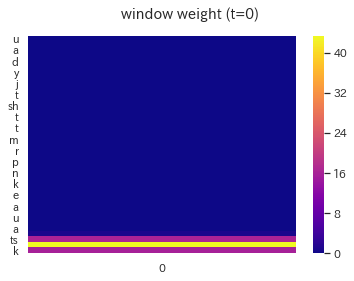

In [343]:
# window weights φ(t, u) during a time step sequence

# the window weight φ(t, u) can be loosely interpreted as
# the network’s belief that it is writing character cu at time t
#frame = pd.DataFrame(w.squeeze(0).detach().numpy(), index=phoneme_names).iloc[::-1]  # reverse by row
frame = pd.DataFrame(phi_t.squeeze(0).detach().numpy(), index=phoneme_names).iloc[::-1]  # reverse by row
sns.heatmap(frame, cmap="plasma")
plt.suptitle('window weight (t=0)')

In [346]:
h2t_1 = H2(xt_1_wt_1_h1t_1, ht_1)
h2t_1.shape

NameError: name 'xt_1_wt_1_h1t_1' is not defined

In [355]:
class Encoder(torch.nn.Module):
    def __init__(self, encode_type:('onehot', 'embed', 'ngc', 'rnn') ='onehot', hidden_size=256):
        self.vocab_size = len(Phoneme43)
        self.encode_type = encode_type
        
        # embedding
        self.hidden_size
        self.embed_size = embed_size
        self.embedding = nn.Embedding(self.vocab_size, hidden_size)
        # n-gram conv (ngc)
        self.ngc = NGramConvolution(embed_size=embed_size, kernel_size=(5, 1))
        # rnn
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(x):
        """
        args:
            - x (batch, sequence_len, vocab_size): onehot encoding
        """
        if len(x.shape) == 1:
            x = torch.LongTensor(to_onehot(phonemes, n_class=vocab_size))
            
        if self.encode_type in ('embed', 'ngc', 'rnn'):
            x = self.embedding(x)
        if self.encode_type in ('ngc', 'rnn'):
            x = ngc(x_emb)
        if self.encode_type == 'rnn':
            out, h = self.gru()
            
        if self.encode_type == 'rnn':
            return out, h
        else:
            return x

In [356]:
class AttentionKGaussianWindow(torch.nn.Module):
    def __init__(self, K=20, hidden_size=256):
        super(AttentionKGaussianWindow, self).__init__()
        self.Wh1p = torch.nn.Linear(hidden_size, 3 * K)
        self.K = K
        self.bp = torch.nn.Parameter(torch.zeros(3*K))
        
    def forward(h1t, kt_1, cx):
        """Compute Attention Window.
        
        h1t: (batch, hidden_size)  Wh1p: (hidden_size, 3K) -> out: (batch, 3K)
        -> alpha, beta, k : (batch, K) x 3
 
        args:
            - h1t of shape (batch, hidden_size): hidden state from the first hidden layer
            - kt_1: previous kappa
            - cx (input_sequence_size, embed_size):
            
        returns:
            - wt: window of time t
            - kt: kappa of time t
            - phi: phi of time t
        """
        
        # (αhat_t, βhat_t, khat_t) = Wh1p ht^1 + bp  # output of the first hidden layer
        alpha_beta_kappa = Wh1p(h1t_1) + bp
        alpha_t, beta_t, kappa_t = alpha_beta_kappa[:, :K], alpha_beta_kappa[:, K:K*2], alpha_beta_kappa[:, K*2:K*3]
        # αt = exp(αhat_t)  # importance of the window
        # βt = exp(βhat_t)  # width of the window
        # κt = κt-1 + exp(κhat_t)  # location of the window (how far to slide each window)
        alpha_t = alpha_t.exp()
        beta_t = beta_t.exp()
        kappa_t = kappa_t_1 + kappa_t.exp()
        alpha_t.shape, beta_t.shape, kappa_t.shape
        
        # φ(t, u) = Σk=1->K αkt*exp(-βkt(κkt-u)^2)  # mixture of K Gaussian
        u = torch.Tensor(range(cx.shape[1]))
        phi_t = (alpha_t.unsqueeze(2) * \
            (-beta_t.unsqueeze(2) * (kappa_t.unsqueeze(2).repeat(1, 1, cx.shape[1]) - u)**2).exp()).sum(dim=1)
        phi_t, phi_t.shape
        
        # wt = Σu=1->U φ(t, u)*cu  # the soft window into c at timestep t
        # The size of the soft window vectors is the same as the size of the character vectors
        # cu (assuming a one-hot encoding, this will be the number of characters in the alphabet).
        wt = (x.float() * phi_t.unsqueeze(2))

        return wt, kappa_t, phi_t

In [360]:
class Decoder(torch.nn.Module):
    def __init__(self, hidden_size=256, out_size=298):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(out_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.gru = torch.nn.GRU(hidden_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, out_size)
    
    def forward(input, h):
        out = self.embedding(input).view(1, 1, -1)
        out = self.relu(out)
        out, h = self.gru(out, h)
        return out, h

In [361]:
class CharToMel(torch.nn.Module):
    def __init__(
            self, encode_type:('onehot', 'embed', 'ngc', 'rnn') ='onehot',
            K=20, hidden_size=256, out_size=298):
        super(CharToMel, self).__init__()
        self.encode_type = encode_type
        self.hidden_size = hidden_size
        self.K = K
        self.encoder = Encoder(encode_type=encode_type, hidden_size=hidden_size)
        self.vocab_size = self.encoder.vocab_size
        self.H1 = torch.nn.GRUCell(input_size=self.vocab_size+3, hidden_size=hidden_size)  # NOTE: 3? window size?
        self.H2 = H2 = torch.nn.GRUCell(input_size=self.vocab_size+3+hidden_size, hidden_size=hidden_size)
        self.window = AttentionKGaussianWindow(K=K, hidden_size=hidden_size)
        self.decoder = Decoder(hidden_size=hidden_size, out_size=298)
        
    def initial_states(batch_size):
        h1_0, h2_0, h3_0 = \
            torch.zeros((batch_size, self.hidden_size)),
            torch.zeros((batch_size, self.hidden_size)),
            torch.zeros((batch_size, self.hidden_size)) 
        kappa_0 = torch.zeros((batch_size, self.K))
        w_0 = torch.zeros((batch_size, 999))  # TODO: window size
        return h1_0, h2_0, h3_0, kappa_0, w_0
        
    def forward(features, labels):
        if self.encode_type in ('onehot'):
            encode_out = self.encoder(labels)
            for t in range(T):
                wt, kappa_t, phi_t = self.window(h1t, kappa_t, labels)
                self.decoder()
        return

In [ ]:
window = Window(K=20, hidden_size=256)
wt_1 = 
for t in range(T):
    # generate next hidden state from mel of time t and previous window of time t-1
    h1t = H1(torch.cat([x[:, t, :], wt_1], dim=-1), yt_1)
    # create attention window with hidden of time t and texts
    wt, kt, phi = window(h1t, kt_1, cx)
    
    

In [ ]:
# h1t = H(Wih1*xt + Wh1h1*h1t-1 + Wwh1*wt-1 + b1h)
h1t = H1(torch.cat([xt.narrow(1, _, 1).squeeze(1), wt_1], dim=-1), ht_1)

In [ ]:
# hnt = H(Wihn*xt + Whn-1hn*hnt-1 + Whnhn*hnt-1 + Wwhn*wt + bnh)
h2t = H2(torch.cat([xt, w1t, h1t_1]), h1t)

In [ ]:
torch.Tensor(100).chunk(3, dim=-1)

In [ ]:
a = torch.Tensor(10, 3)

In [ ]:
ln = torch.nn.Linear(3, 5)

In [ ]:
ln(a).shape

In [ ]:
input.shape

In [ ]:
kt = torch.Tensor((3)).view(1, -1)
at = torch.Tensor((3)).view(1, -1)

In [ ]:
kt, at

In [ ]:
u = torch.Tensor(range(44))
u

In [ ]:
K_U = torch.ones((3,44))
K_U

In [ ]:
K_U - u

In [ ]:
(at.unsqueeze(2)*((kt.unsqueeze(2).repeat(1, 1, 44) - u)**2).exp()).sum(dim=1)